[__<< Exploratory Data Analysis__](./03_Divvy_exploratory_data_analysis.ipynb) | [__Home__](../README.md) | [__Modeling & Validation >>__](./05_Divvy_modeling.ipynb)

# Divvy: Bike Sharing Forecast
## Feature Engineering

__Dataset:__ [Divvy Data](https://divvybikes.com/system-data) \
__Author:__ [Dmitry Luchkin](https://www.linkedin.com/in/dmitry-luchkin/) \
__Date:__ March 2025

### Notebooks <a class="anchor" name='notebooks'></a>

+ [Initial Data Exploration](./01_Divvy_data_exploration.ipynb)
+ [Data Cleaning](./02_Divvy_data_cleaning.ipynb)
+ [Exploratory Data Analysis](./03_Divvy_exploratory_data_analysis.ipynb)
+ __[Feature Engineering](./04_Divvy_feature_engineering.ipynb)__
+ [Modeling & Validation](./05_Divvy_forecasting.ipynb)

### Import Libraries <a name='import-libraries'></a>

In [1]:
import datetime
import sys
import re
import pickle
import warnings
import holidays

import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../02_scripts/')
warnings.filterwarnings("ignore")

%matplotlib inline

### Notebook Setup <a name='notebook-setup'></a>

In [2]:
# Pandas settings
pd.options.display.max_rows = 20
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 60
pd.options.display.float_format = '{:,.4f}'.format

# Visualization settings
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = (16, 5)   
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.size'] = 12
rcParams['savefig.dpi'] = 300
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
%config InlineBackend.figure_format = 'retina'

In [3]:
from IPython.display import Markdown
from IPython.core.magic import register_cell_magic


@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

### ToDo's <a name='todos'></a>

In [4]:
# get all tasks from the previous phase

sys.path.append('../02_scripts/')
from todo_list import extract_todo_patterns

print(f'{'-'*5} TASKS FROM PREVIOUS PHASE {'-'*5}')
for todo in extract_todo_patterns('./03_Divvy_exploratory_data_analysis.ipynb'):
    print(f'TODO: {todo}')

----- TASKS FROM PREVIOUS PHASE -----


### Loading Data <a name='loading-data'></a>

In [5]:
%store -r data_divvy

In [6]:
data = data_divvy

In [7]:
#%store -d data_divvy

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25478652 entries, 0 to 26384907
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   start_station_id    object        
 5   end_station_name    object        
 6   end_station_id      object        
 7   start_lat           float64       
 8   start_lng           float64       
 9   end_lat             float64       
 10  end_lng             float64       
 11  rider_type          category      
 12  bike_type           category      
 13  year                int32         
 14  quarter             category      
 15  month               category      
 16  day                 int32         
 17  hour                int32         
 18  minute              int32         
 19  season              category      
 20  weekd

### Feature Engineering <a name='feature-engineering'></a>

#### Pivot Features

In [9]:
data.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type,bike_type,year,quarter,month,day,hour,minute,season,weekday,part_day,duration_min,distance_km,avg_speed_kmph
0,BD0A6FF6FFF9B921,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0000,St. Clair St & Erie St,211.0000,41.8942,-87.6291,41.8944,-87.6234,casual,electric_bike,2020,Q4,November,1,13,36,Autumn,Sunday,Noon,9.6667,0.4779,2.9662
1,96A7A7A4BDE4F82D,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0000,Noble St & Milwaukee Ave,29.0000,41.8910,-87.6353,41.9007,-87.6625,casual,electric_bike,2020,Q4,November,1,10,3,Autumn,Sunday,Morning,11.3167,2.4973,13.2403
2,C61526D06582BDC5,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0000,Federal St & Polk St,41.0000,41.8810,-87.6168,41.8721,-87.6296,casual,electric_bike,2020,Q4,November,1,0,34,Autumn,Sunday,Late Night,29.0167,1.4532,3.0049
3,E533E89C32080B9E,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0000,Stave St & Armitage Ave,185.0000,41.8955,-87.6820,41.9177,-87.6914,casual,electric_bike,2020,Q4,November,1,0,45,Autumn,Sunday,Late Night,9.2500,2.5905,16.8030
4,1C9F4EF18C168C60,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0000,Buckingham Fountain,2.0000,41.8765,-87.6204,41.8764,-87.6203,casual,electric_bike,2020,Q4,November,1,15,43,Autumn,Sunday,Noon,33.4500,0.0057,0.0102


In [10]:
for rider_type, bike_type in data.value_counts(["rider_type", "bike_type"]).index:
    print(f"{rider_type}-{bike_type}")

member-regular_bike
member-electric_bike
casual-regular_bike
casual-electric_bike


Create pivot features of number of rides.

In [11]:
# group rides by "started_at" date rounded to day, rides type and bike type and count the rides
grouped = data.groupby([pd.Grouper(key='started_at', axis=0,  
                      freq='D'), 'rider_type', 'bike_type'], observed=True).size().reset_index(name='count')
# widen the grouped data and count the rides by ride type and bike type
grouped_wide = grouped.pivot(index='started_at', columns=['rider_type', 'bike_type'], values='count').reset_index()
# prefixes fot column names
flat_index = grouped_wide.columns.to_flat_index()
# set new column names
grouped_wide.columns = ['_'.join(col) for col in flat_index]
# fill all NaN
grouped_wide.fillna(0, inplace=True)

# calculate total's
grouped_wide['member_total'] = grouped_wide['member_electric_bike'] + grouped_wide['member_regular_bike']
grouped_wide['casual_total'] = grouped_wide['casual_electric_bike'] + grouped_wide['casual_regular_bike']
grouped_wide['electric_total'] = grouped_wide['casual_electric_bike'] + grouped_wide['member_electric_bike']
grouped_wide['regular_total'] = grouped_wide['casual_regular_bike'] + grouped_wide['member_regular_bike']

grouped_wide['total_rides'] = grouped_wide['electric_total'] + grouped_wide['regular_total']

grouped_wide.rename(columns={'started_at_': 'date'}, inplace=True)

In [12]:
full_range = pd.date_range(start=grouped_wide["date"].min(), end=grouped_wide["date"].max(), freq='D')

# check missing dates
missing_dates = full_range.difference(grouped_wide["date"])

print("Missing dates:")
print(missing_dates)

Missing dates:
DatetimeIndex(['2020-06-01', '2020-06-02'], dtype='datetime64[ns]', freq='D')


In [13]:
grouped_wide.set_index("date", inplace=True)
grouped_wide = grouped_wide.asfreq("D")

grouped_wide.head()

,casual_regular_bike,member_regular_bike,casual_electric_bike,member_electric_bike,member_total,casual_total,electric_total,regular_total,total_rides
date,,,,,,,,,
2020-01-01,474.0000,"1,645.0000",0.0000,0.0000,"1,645.0000",474.0000,0.0000,"2,119.0000","2,119.0000"
2020-01-02,661.0000,"5,768.0000",0.0000,0.0000,"5,768.0000",661.0000,0.0000,"6,429.0000","6,429.0000"
2020-01-03,451.0000,"5,402.0000",0.0000,0.0000,"5,402.0000",451.0000,0.0000,"5,853.0000","5,853.0000"
2020-01-04,388.0000,"2,767.0000",0.0000,0.0000,"2,767.0000",388.0000,0.0000,"3,155.0000","3,155.0000"
2020-01-05,430.0000,"2,565.0000",0.0000,0.0000,"2,565.0000",430.0000,0.0000,"2,995.0000","2,995.0000"


Check missing dates.

In [14]:
grouped_wide[grouped_wide["total_rides"].isna()]

,casual_regular_bike,member_regular_bike,casual_electric_bike,member_electric_bike,member_total,casual_total,electric_total,regular_total,total_rides
date,,,,,,,,,
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fill the missing dates with a linear interpolation.

In [15]:
grouped_wide.interpolate(axis=0, method='linear', limit_direction='both', inplace=True)

In [16]:
grouped_wide["total_rides"].isna().sum()

0

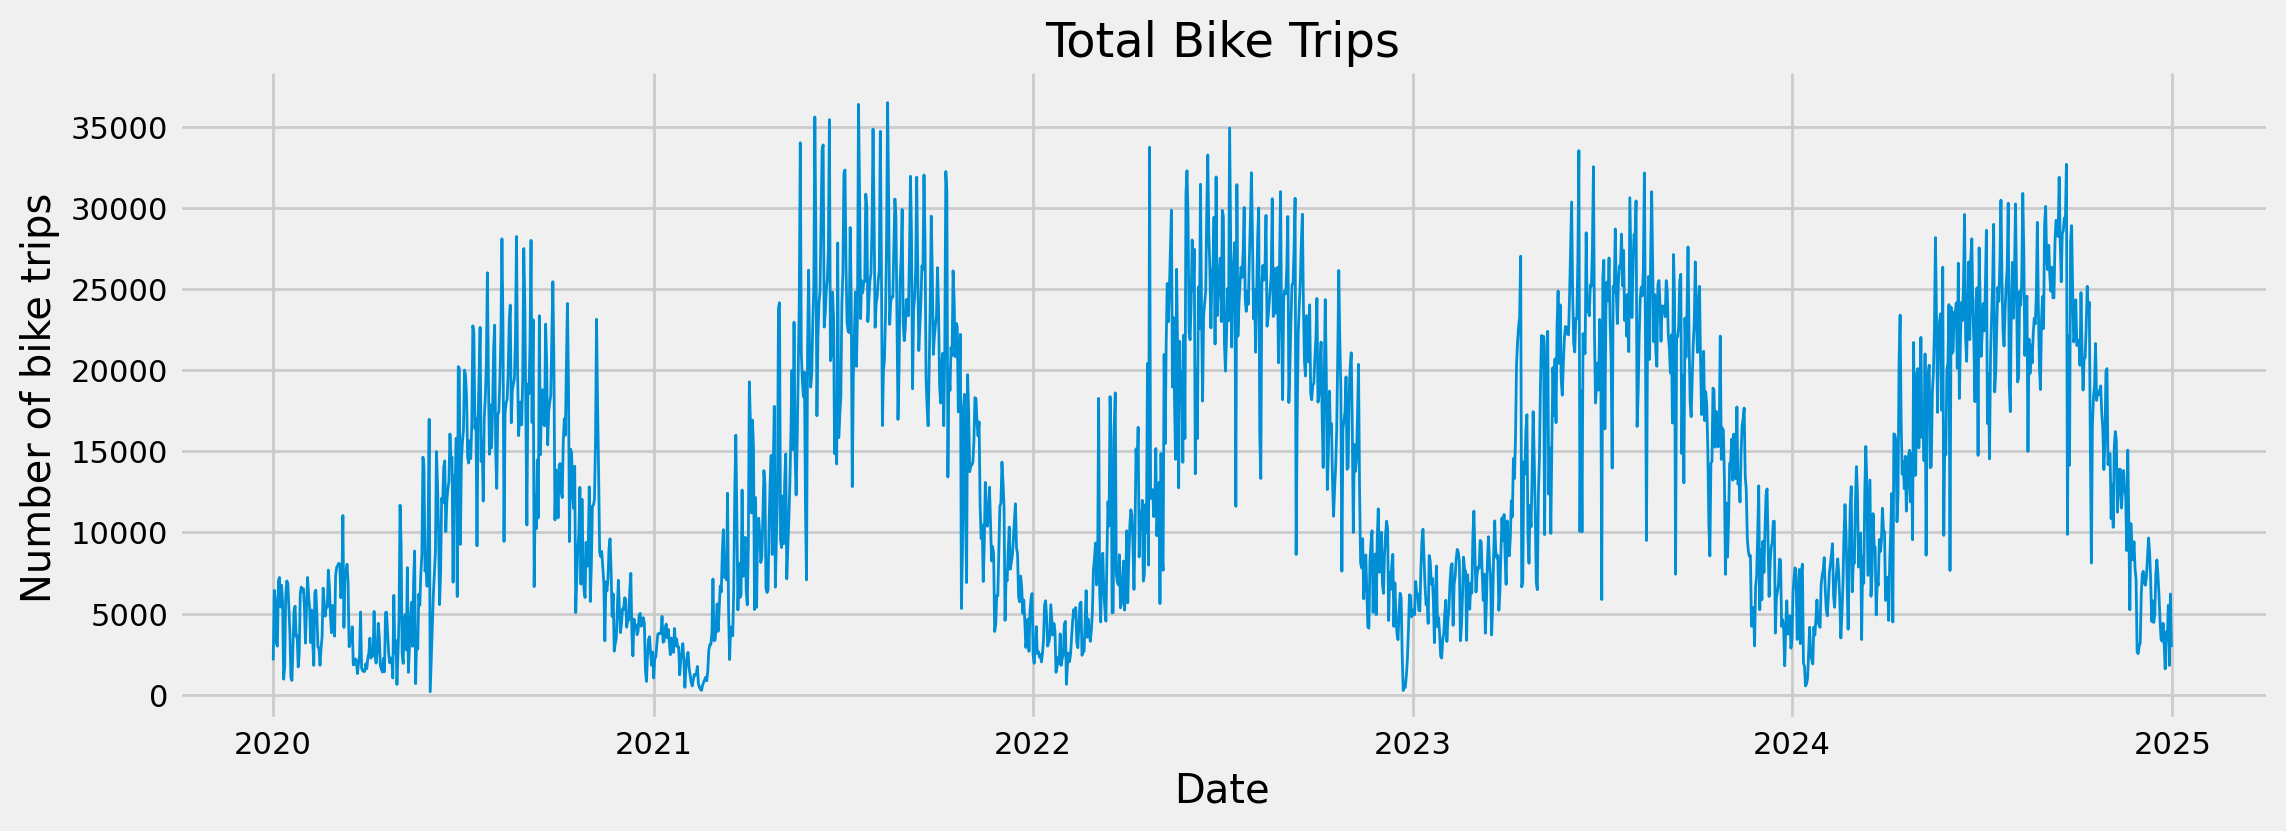

In [17]:
plt.figure(figsize=(12, 4))

plt.plot(grouped_wide["total_rides"], lw=1)

plt.title("Total Bike Trips")
plt.xlabel("Date")
plt.ylabel("Number of bike trips")

plt.show()

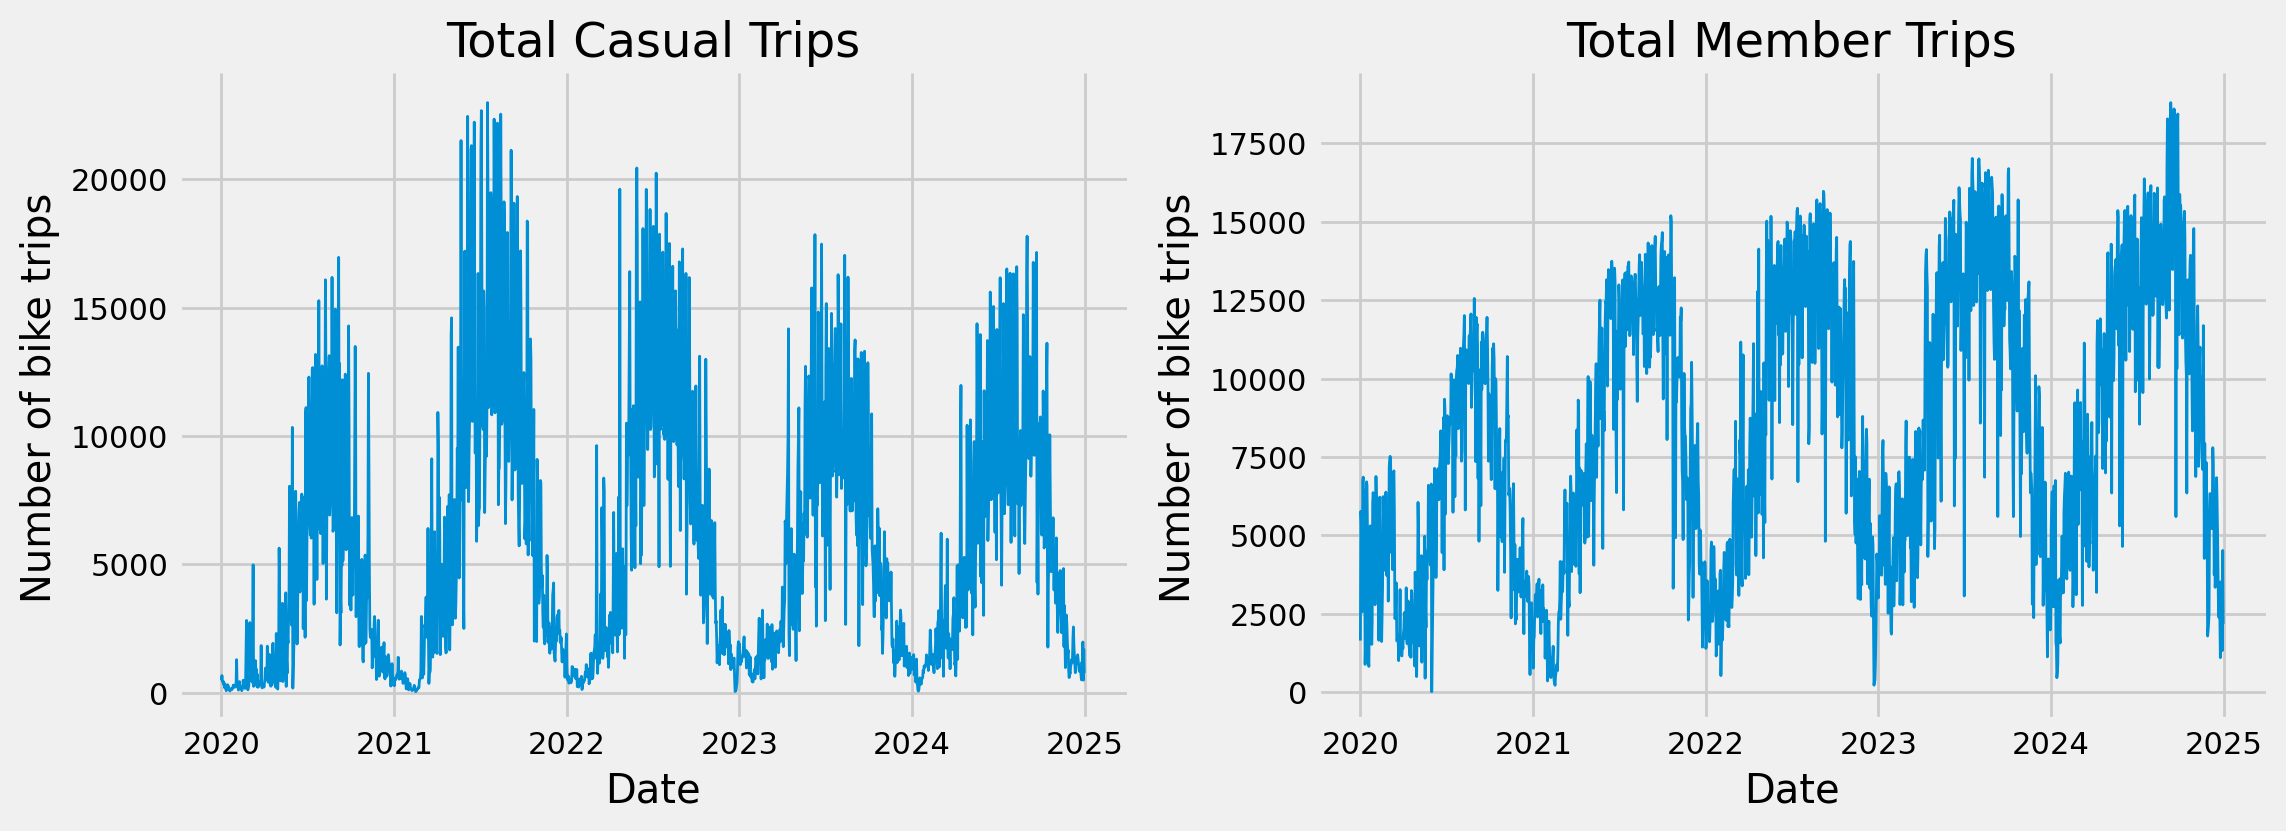

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(grouped_wide["casual_total"], lw=1)
ax[0].set_title("Total Casual Trips")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Number of bike trips")

ax[1].plot(grouped_wide["member_total"], lw=1)
ax[1].set_title("Total Member Trips")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Number of bike trips")

plt.show()

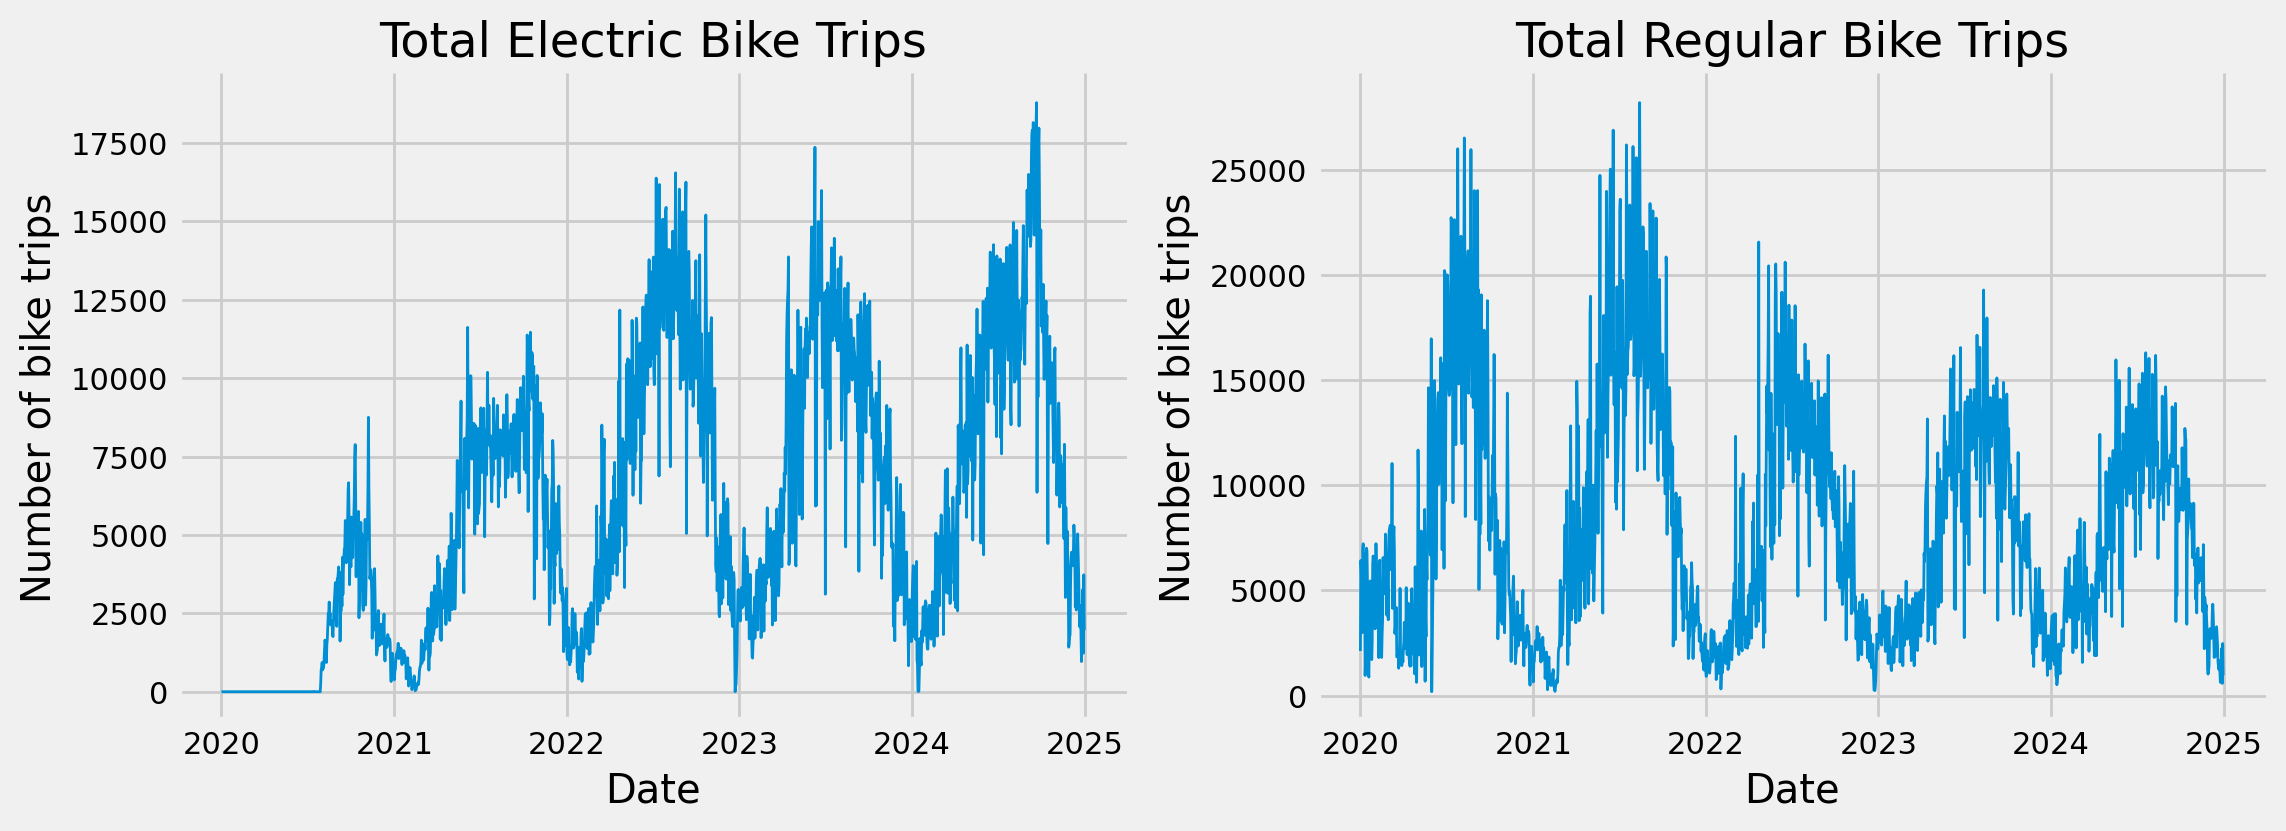

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(grouped_wide["electric_total"], lw=1)
ax[0].set_title("Total Electric Bike Trips")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Number of bike trips")

ax[1].plot(grouped_wide["regular_total"], lw=1)
ax[1].set_title("Total Regular Bike Trips")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Number of bike trips")

plt.show()

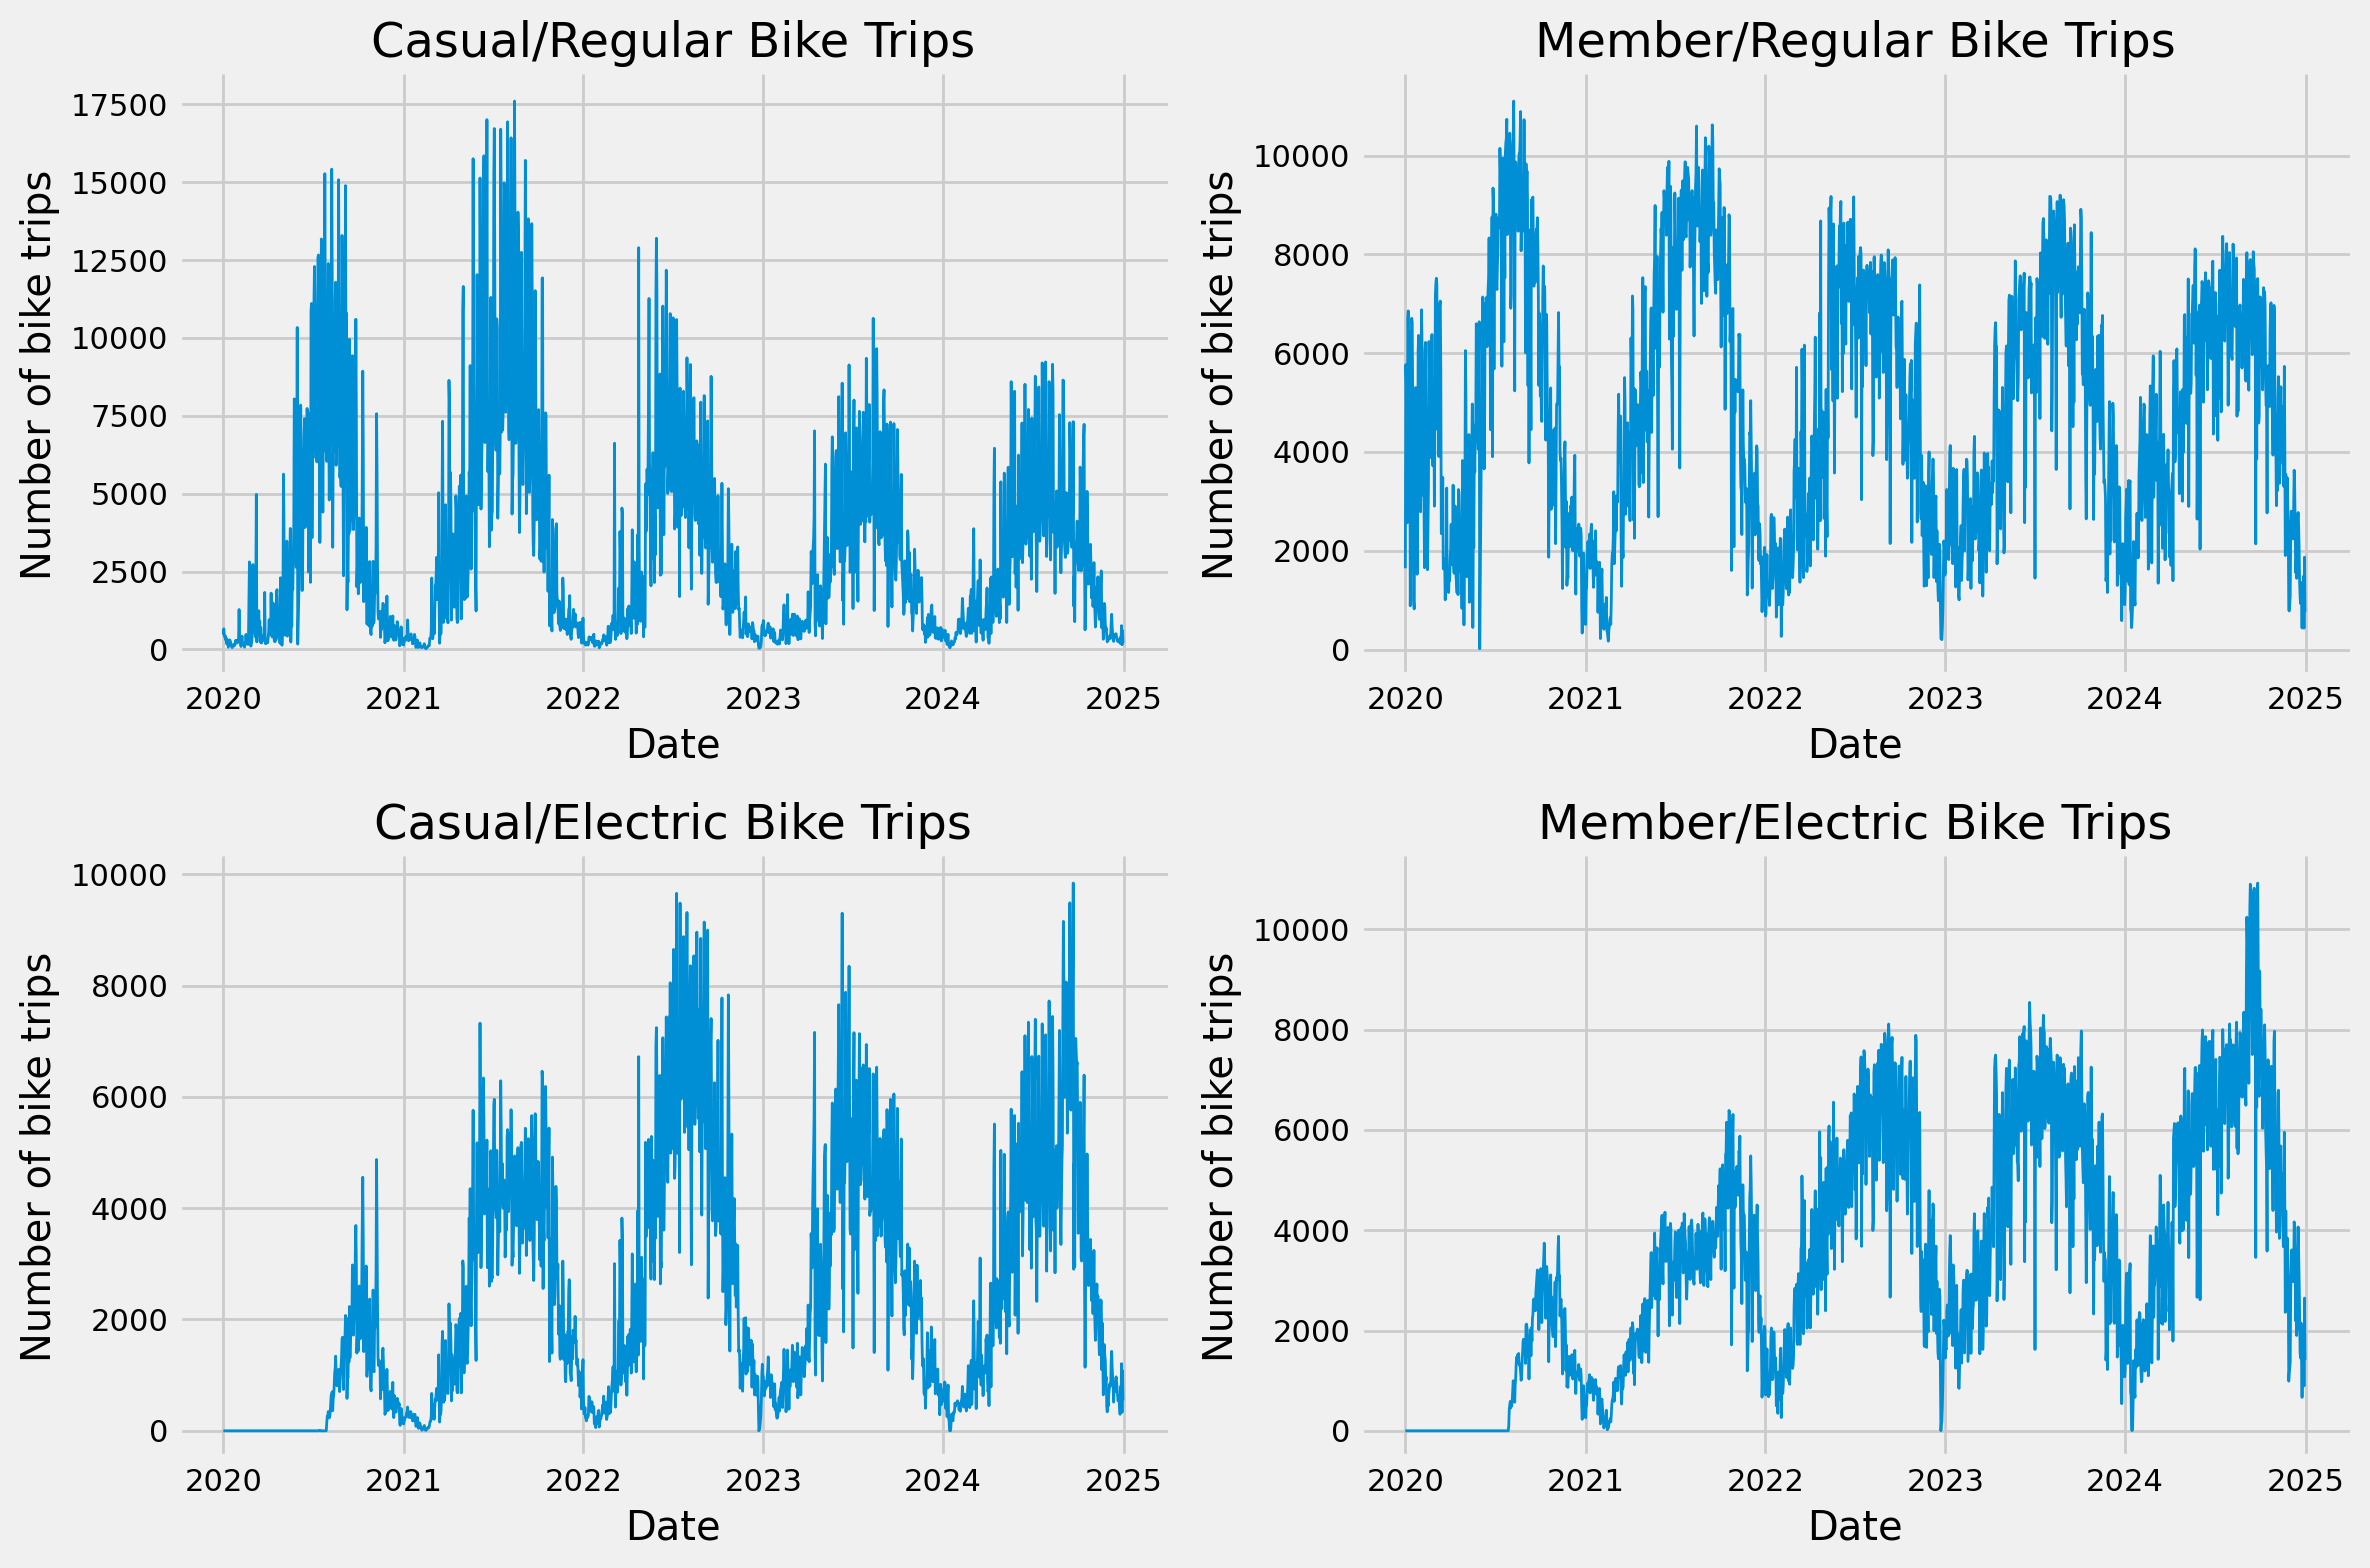

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(grouped_wide["casual_regular_bike"], lw=1)
ax[0, 0].set_title("Casual/Regular Bike Trips")
ax[0, 0].set_xlabel("Date")
ax[0, 0].set_ylabel("Number of bike trips")

ax[0, 1].plot(grouped_wide["member_regular_bike"], lw=1)
ax[0, 1].set_title("Member/Regular Bike Trips")
ax[0, 1].set_xlabel("Date")
ax[0, 1].set_ylabel("Number of bike trips")

ax[1, 0].plot(grouped_wide["casual_electric_bike"], lw=1)
ax[1, 0].set_title("Casual/Electric Bike Trips")
ax[1, 0].set_xlabel("Date")
ax[1, 0].set_ylabel("Number of bike trips")

ax[1, 1].plot(grouped_wide["member_electric_bike"], lw=1)
ax[1, 1].set_title("Member/Electric Bike Trips")
ax[1, 1].set_xlabel("Date")
ax[1, 1].set_ylabel("Number of bike trips")

plt.tight_layout()
plt.show()

__Observations:__

+ In 2020, there was a noticeable drop in the number of bike trips, likely due to the COVID-19 pandemic and lockdown restrictions that lasted until around May. After that, the total number of trips gradually recovered. However, starting from 2021, a stagnation in total trips can be observed.
+ Electric bikes became available in the second half of 2020, which significantly changed the dynamics of bike usage. Since the initial period overlaps with pandemic-related restrictions, it may not fully reflect typical user behavior. Therefore, it makes sense to train forecasting models on data from 2021 onward, when unrestricted mobility resumed and the impact of COVID-19 on transportation patterns diminished.
+ There is a clear year-over-year increase in the number of electric bike trips, while the usage of regular bikes shows a declining trend. This shift suggests a growing preference for electric bikes among users over time.

#### Weather Features

The weather data were downloaded from [visualcrossing.com](https://www.visualcrossing.com/)

In [21]:
import os
files = ['../00_data/00_raw/weather/' + file for file in os.listdir('../00_data/00_raw/weather/') if file.endswith('.csv')]

def load(x):
    print(f'{x} loading...')
    return pd.read_csv(x)

weather = pd.concat(map(load, files), ignore_index=True)

../00_data/00_raw/weather/Chicago, IL, United State... 2025-01-01 to 2025-06-30.csv loading...
../00_data/00_raw/weather/Chicago,United States 2020-01-01 to 2020-12-31.csv loading...
../00_data/00_raw/weather/Chicago, IL, United State... 2024-07-01 to 2024-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2022-01-01 to 2022-06-30.csv loading...
../00_data/00_raw/weather/Chicago,United States 2024-01-01 to 2024-06-30.csv loading...
../00_data/00_raw/weather/Chicago,United States 2021-01-01 to 2021-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2022-07-01 to 2022-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2023-01-01 to 2023-12-31.csv loading...


In [22]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2008 non-null   object 
 1   datetime          2008 non-null   object 
 2   tempmax           2008 non-null   float64
 3   tempmin           2008 non-null   float64
 4   temp              2008 non-null   float64
 5   feelslikemax      2008 non-null   float64
 6   feelslikemin      2008 non-null   float64
 7   feelslike         2008 non-null   float64
 8   dew               2008 non-null   float64
 9   humidity          2008 non-null   float64
 10  precip            2008 non-null   float64
 11  precipprob        2008 non-null   float64
 12  precipcover       2008 non-null   float64
 13  preciptype        847 non-null    object 
 14  snow              1925 non-null   float64
 15  snowdepth         1933 non-null   float64
 16  windgust          1946 non-null   float64


In [23]:
weather.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [24]:
weather['datetime'] = pd.to_datetime(weather['datetime'], format='mixed')

In [25]:
weather.sort_values(by='datetime').head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
181,"Chicago,United States",2020-01-01,6.1000,-5.5000,0.5000,1.8000,-10.7000,-4.2000,-4.4000,71.1000,0.0000,0.0000,0.0000,snow,0.1000,1.2000,51.2000,31.5000,207.9000,"1,007.3000",32.0000,15.9000,97.6000,8.4000,4.0000,NaN,2020-01-01T07:18:18,2020-01-01T16:29:47,0.2100,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,KPWK,D6362"
182,"Chicago,United States",2020-01-02,8.9000,3.0000,6.0000,6.2000,-1.7000,2.4000,0.5000,68.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.1000,49.1000,29.7000,214.1000,"1,002.4000",43.2000,16.0000,84.6000,7.3000,4.0000,NaN,2020-01-02T07:18:24,2020-01-02T16:30:39,0.2500,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,KPWK,D6362"
183,"Chicago,United States",2020-01-03,5.3000,1.4000,3.0000,3.4000,-2.0000,0.4000,-0.9000,76.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,NaN,13.9000,335.7000,"1,009.8000",91.4000,15.6000,27.0000,2.4000,1.0000,NaN,2020-01-03T07:18:26,2020-01-03T16:31:33,0.2700,Overcast,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,74466504838,KPWK,D6362"
184,"Chicago,United States",2020-01-04,1.4000,-2.2000,-0.2000,-2.1000,-7.4000,-4.7000,-4.4000,73.4000,0.3780,100.0000,12.5000,"rain,snow",0.2000,0.1000,33.5000,22.2000,313.1000,"1,016.5000",89.8000,13.6000,20.1000,1.8000,2.0000,NaN,2020-01-04T07:18:27,2020-01-04T16:32:28,0.3100,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or snow clear...,snow,"72534014819,KORD,KMDW,72530094846,74466504838,KPWK,D6362"
185,"Chicago,United States",2020-01-05,6.0000,-3.9000,0.8000,2.0000,-10.1000,-4.4000,-3.7000,72.4000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,59.4000,34.1000,238.8000,"1,016.2000",73.0000,15.8000,61.4000,5.4000,4.0000,NaN,2020-01-05T07:18:25,2020-01-05T16:33:24,0.3400,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,74466504838,KPWK,D6362"


In [26]:
weather.drop(columns=['name', 'tempmax', 'tempmin', 'feelslikemax',
                      'feelslikemin', 'dew', 'preciptype', 'solarradiation', 
                      'solarenergy', 'uvindex', 'severerisk', 'sunrise',
                      'sunset', 'moonphase', 'description', 'icon', 'stations'], inplace=True)

In [27]:
df_split = weather["conditions"].str.get_dummies(sep=", ")
weather = pd.concat([weather, df_split], axis=1)
weather.drop(["conditions"], axis=1, inplace=True)
weather.set_index("datetime", inplace=True)
weather = weather.asfreq("D")
weather.head()

,temp,feelslike,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.5000,-4.2000,71.1000,0.0000,0.0000,0.0000,0.1000,1.2000,51.2000,31.5000,207.9000,"1,007.3000",32.0000,15.9000,0,0,0,0,1,0,0
2020-01-02,6.0000,2.4000,68.0000,0.0000,0.0000,0.0000,0.0000,0.1000,49.1000,29.7000,214.1000,"1,002.4000",43.2000,16.0000,0,0,0,0,1,0,0
2020-01-03,3.0000,0.4000,76.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,13.9000,335.7000,"1,009.8000",91.4000,15.6000,0,0,0,1,0,0,0
2020-01-04,-0.2000,-4.7000,73.4000,0.3780,100.0000,12.5000,0.2000,0.1000,33.5000,22.2000,313.1000,"1,016.5000",89.8000,13.6000,0,0,0,0,1,1,1
2020-01-05,0.8000,-4.4000,72.4000,0.0000,0.0000,0.0000,0.0000,0.0000,59.4000,34.1000,238.8000,"1,016.2000",73.0000,15.8000,0,0,0,0,1,0,0


#### Timestamp Features

In [28]:
def add_timestamp_features(df):
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['season'] = df['month'] % 12 // 3 + 1 
    df['weekday'] = df.index.dayofweek
    
    return df

def add_lags(df, y_col_name, lags=[1, 7, 12, 30, 365]):
    for lag in lags:
        df[f"lag_{lag}"] = df[y_col_name].shift(lag)
    
    df = df.dropna()
    
    return df


##### Holidays Feature

**Chicago Holidays 2025 (with Federal Status)**

| Holiday Name                         | Date Rule / Description               | Federal Holiday?             |
|--------------------------------------|----------------------------------------|------------------------------|
| New Year's Day                       | January 1                              | Yes                          |
| Martin Luther King Jr. Day           | 3rd Monday of January                  | Yes                          |
| Lincoln's Birthday                   | February 12                            | No (Illinois Only)           |
| Washington's Birthday (Presidents Day) | 3rd Monday of February               | Yes                          |
| Pulaski Day                          | 1st Monday of March                    | No (Chicago/Illinois Only)   |
| Memorial Day                         | Last Monday of May                     | Yes                          |
| Juneteenth National Independence Day | June 19                                | Yes                          |
| Independence Day                     | July 4                                 | Yes                          |
| Labor Day                            | 1st Monday of September                | Yes                          |
| Columbus Day                         | 2nd Monday of October                  | Yes                          |
| Veterans Day                         | November 11                            | Yes                          |
| Thanksgiving Day                     | 4th Thursday of November               | Yes                          |
| Christmas Day                        | December 25                            | Yes                          |


In [29]:
us_il_holidays = holidays.country_holidays('US', subdiv='IL')
us_il_holidays

holidays.country_holidays('US', subdiv='IL')

In [30]:
import holidays

def add_holiday_feature(df):
    us_il_holidays = holidays.country_holidays('US', subdiv='IL')
    df["is_holiday"] = df.index.map(lambda x: x in us_il_holidays)
    df["is_holiday"] = df["is_holiday"].astype(np.int32)
    
    return df

In [31]:
pivot_data = grouped_wide
add_holiday_feature(pivot_data)
add_timestamp_features(pivot_data)

pivot_data = pd.concat([pivot_data, weather], join="inner",  axis=1)

pivot_data = pivot_data[pivot_data.index.year > 2020]

pivot_data.head()

,casual_regular_bike,member_regular_bike,casual_electric_bike,member_electric_bike,member_total,casual_total,electric_total,regular_total,total_rides,is_holiday,year,quarter,month,day,season,weekday,temp,feelslike,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
2021-01-01,142.0000,507.0000,122.0000,258.0000,765.0000,264.0000,380.0000,649.0000,"1,029.0000",1,2021,1,1,1,1,4,-0.7000,-5.4000,82.8000,7.0450,100.0000,50.0000,2.1000,3.2000,52.2000,36.0000,50.9000,"1,017.7000",94.9000,8.2000,0,0,0,1,0,1,1
2021-01-02,360.0000,"1,196.0000",174.0000,498.0000,"1,694.0000",534.0000,672.0000,"1,556.0000","2,228.0000",0,2021,1,1,2,1,5,0.5000,-2.8000,85.2000,0.0000,0.0000,0.0000,1.4000,2.1000,46.1000,19.8000,2.9000,"1,017.8000",99.9000,9.3000,0,0,0,1,0,0,0
2021-01-03,365.0000,"1,255.0000",198.0000,506.0000,"1,761.0000",563.0000,704.0000,"1,620.0000","2,324.0000",0,2021,1,1,3,1,6,-0.2000,-3.5000,85.4000,1.0540,100.0000,20.8300,0.1000,0.8000,24.8000,14.9000,275.9000,"1,015.8000",99.8000,9.6000,0,0,0,1,0,1,1
2021-01-04,272.0000,"1,796.0000",236.0000,796.0000,"2,592.0000",508.0000,"1,032.0000","2,068.0000","3,100.0000",0,2021,1,1,4,1,0,-2.6000,-7.2000,88.3000,0.0000,0.0000,0.0000,0.0000,0.8000,29.5000,19.7000,219.4000,"1,016.2000",100.0000,6.0000,0,0,0,1,0,0,0
2021-01-05,382.0000,"2,164.0000",244.0000,947.0000,"3,111.0000",626.0000,"1,191.0000","2,546.0000","3,737.0000",0,2021,1,1,5,1,1,0.2000,-2.7000,82.4000,0.0000,0.0000,0.0000,0.0000,0.8000,26.6000,16.3000,296.4000,"1,020.2000",99.0000,11.4000,0,0,0,1,0,0,0


In [32]:
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2021-01-01 to 2024-12-31
Freq: D
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   casual_regular_bike             1461 non-null   float64
 1   member_regular_bike             1461 non-null   float64
 2   casual_electric_bike            1461 non-null   float64
 3   member_electric_bike            1461 non-null   float64
 4   member_total                    1461 non-null   float64
 5   casual_total                    1461 non-null   float64
 6   electric_total                  1461 non-null   float64
 7   regular_total                   1461 non-null   float64
 8   total_rides                     1461 non-null   float64
 9   is_holiday                      1461 non-null   int32  
 10  year                            1461 non-null   int32  
 11  quarter                         1461 non-null   int32  
 12  month   

### Save the Data <a name='save-data'></a>

In [33]:
# save processed dataset for modeling

filename = '../00_data/02_processed/divvy_data_processed_final.pkl'
pickle.dump(pivot_data, open(filename, 'wb'))


---
\
[__<< Exploratory Data Analysis__](./03_Divvy_exploratory_data_analysis.ipynb) | [__Home__](../README.md) | [__Modeling & Validation >>__](./05_Divvy_forecasting.ipynb)
\
\
Divvy: Bike Sharing Forecast, _March 2025_